In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()




Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle competitions download -c cs-480-2024-spring

100% 287M/287M [00:14<00:00, 24.5MB/s]
100% 287M/287M [00:14<00:00, 21.4MB/s]


In [ ]:
import zipfile

# Specify the path to the zip file
zip_path = '/content/cs-480-2024-spring.zip'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')
    print("Extraction complete")

# Optionally, list the extracted files
import os
extracted_files = os.listdir('/content')
print("Extracted files:", extracted_files)



Extraction complete
Extracted files: ['.config', 'drive', 'data', 'cs-480-2024-spring.zip', 'sample_data']


In [ ]:
import os

directory = '/content/data/train_images'

# Count the number of files in the directory
num_files = len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

print(f"Number of files: {num_files}")


Number of files: 43363


0       154220505
1       195736552
2       182701773
3        27688500
4       195825045
          ...    
6386    195615880
6387    126224052
6388    178518157
6389    158746703
6390    104965612
Name: id, Length: 6391, dtype: int64
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


<Figure size 1000x600 with 0 Axes>

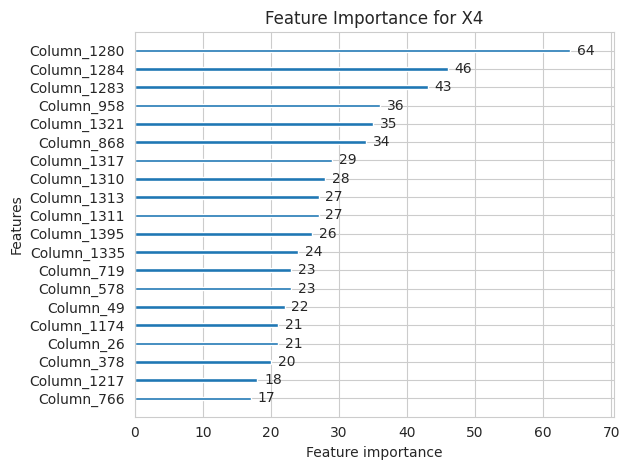

<Figure size 1000x600 with 0 Axes>

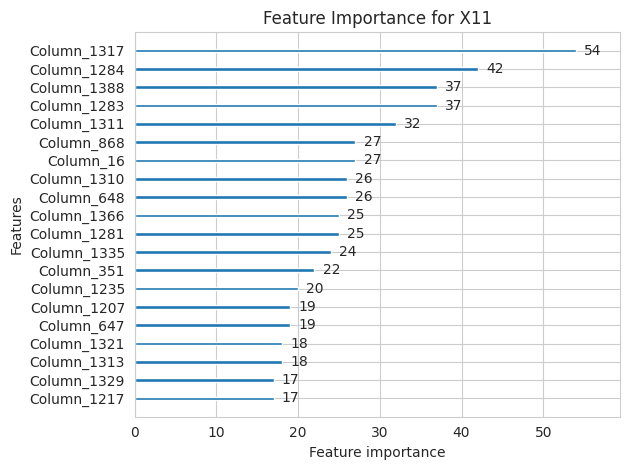

<Figure size 1000x600 with 0 Axes>

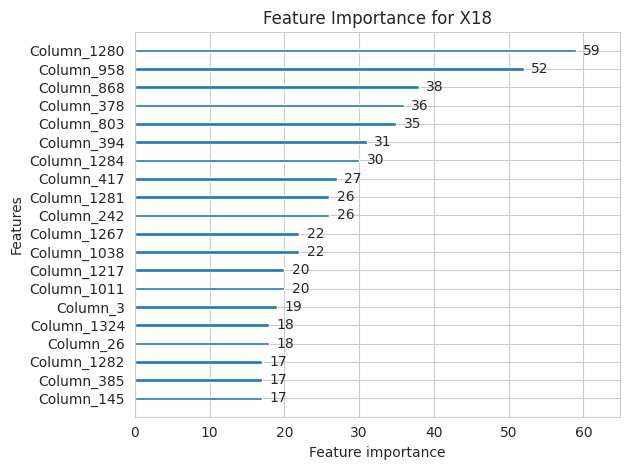

<Figure size 1000x600 with 0 Axes>

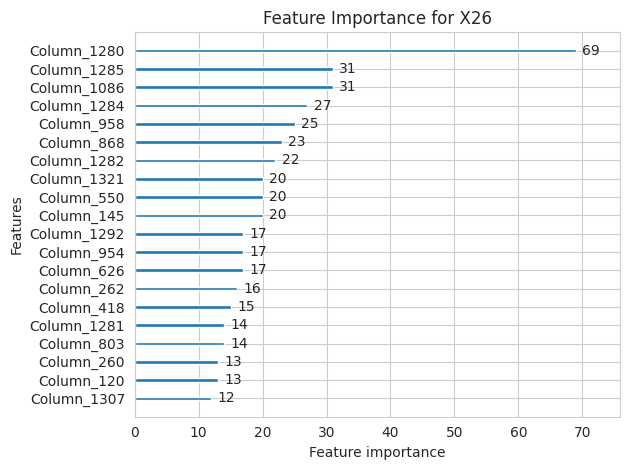

<Figure size 1000x600 with 0 Axes>

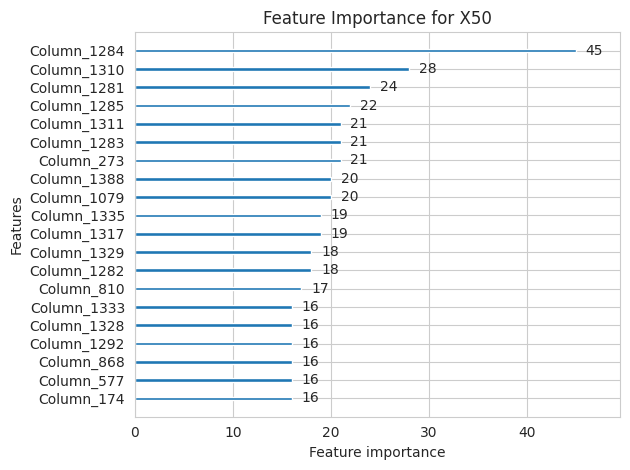

<Figure size 1000x600 with 0 Axes>

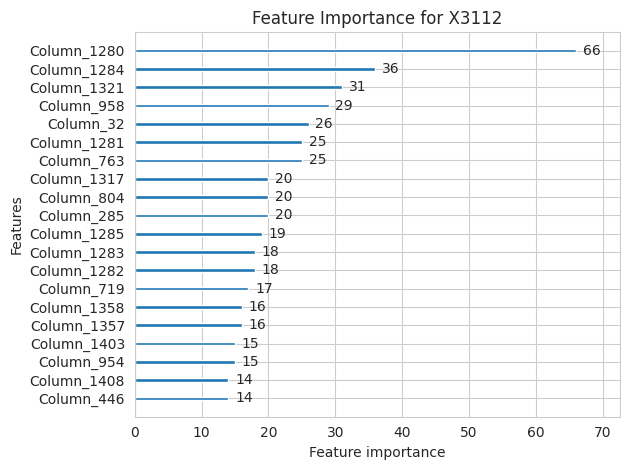

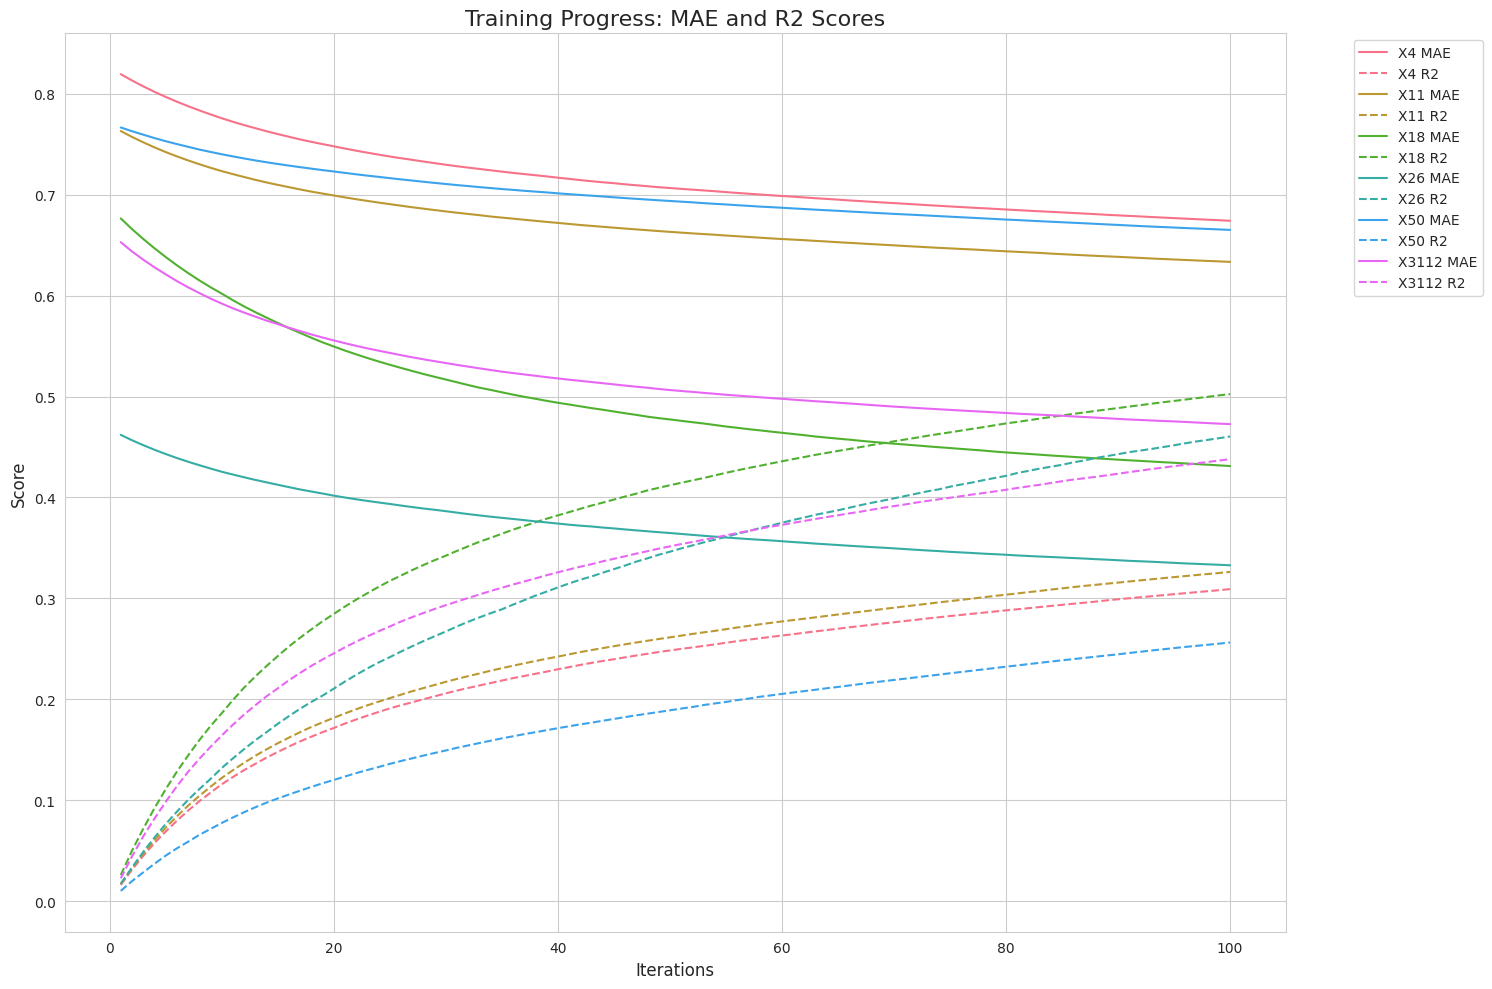

          id        X4         X11           X18          X26        X50  \
0  154220505  1.111748  146.194146  19708.480530  3558.862204  15.091229   
1  195736552  1.066713  149.314359  19702.439760  3484.077147  15.172800   
2  182701773  0.957675  150.296598  19699.711018  3464.649928  15.101483   
3   27688500  1.036237  144.648319  19700.004129  3469.371862  15.617977   
4  195825045  0.977030  151.194803  19699.548053  3464.855168  15.077998   

           X3112  
0  403191.965706  
1  399303.807222  
2  398275.627483  
3  398724.833059  
4  398643.975875  


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
import lightgbm as lgb

# Step 1: Load and preprocess the images
def preprocess_image(image_path):
    img = load_img(image_path)
    img_array = img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

# Step 2: Load the CSV data
csv_data = pd.read_csv('/content/data/train.csv')
sample_size = len(csv_data)
csv_vectors = csv_data[:sample_size]

# training vectors
training_vectors = csv_vectors.iloc[:, 1:164].values
# training ids
training_ids = csv_vectors['id']

#training image_paths
training_image_paths = [os.path.join('/content/data/train_images', str(id) + '.jpeg') for id in training_ids]
images = np.array([preprocess_image(path) for path in training_image_paths])

# test data preparation
test_data = pd.read_csv('/content/data/test.csv')
test_ids = test_data['id']
test_image_paths = [os.path.join('/content/data/test_images', str(id) + '.jpeg') for id in test_ids]
test_images = np.array([preprocess_image(path) for path in test_image_paths])
test_vectors = test_data.iloc[:, 1:164].values

# Allocate a new DataFrame to hold predictions
predictions_df = pd.DataFrame(columns=['id', 'X4', 'X11', 'X18', 'X26', 'X50', 'X3112'])
predictions_df['id'] = test_data['id']

# Extract image features using MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(128, 128, 3))
image_features = base_model.predict(images)
test_image_features = base_model.predict(test_images)

# Combine image features with other features
combined_features = np.concatenate([image_features, training_vectors], axis=1)
test_combined_features = np.concatenate([test_image_features, test_vectors], axis=1)

# Custom R2 score function for LightGBM
def r2_score_func(preds, train_data):
    labels = train_data.get_label()
    return 'r2', r2_score(labels, preds), True

# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': ['mae', 'rmse'],  # Specify both MAE and RMSE
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
# Set up color palette
colors = sns.color_palette("husl", 6)

# Dictionary to store results for final plotting
final_results = {}

for idx, column in enumerate(['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']):
    # Create a StandardScaler object
    scaler = StandardScaler()

    # Prepare the target values
    y = csv_vectors[column].values

    # Normalize the target values
    y_normalized = scaler.fit_transform(y.reshape(-1, 1)).ravel()

    # Initialize a dictionary to store evaluation results
    evals_result = {}

    # Create LightGBM datasets
    lgb_train = lgb.Dataset(combined_features, y_normalized)

    # Train LightGBM model with evaluation metric recorded
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=100,
        valid_sets=[lgb_train],
        feval=r2_score_func,
        callbacks=[lgb.record_evaluation(evals_result)]
    )

    # Make predictions
    predictions = model.predict(test_combined_features)

    # Inverse transform the predictions to get the original scale
    predictions_original_scale = scaler.inverse_transform(predictions.reshape(-1, 1)).ravel()

    # Write prediction to the DataFrame
    column_name = column[:-5]
    predictions_df[column_name] = predictions_original_scale

    # Store results for final plotting
    final_results[column_name] = {
        'mae': evals_result['training'].get('mae', evals_result['training'].get('l1', [])),
        'rmse': evals_result['training'].get('rmse', evals_result['training'].get('l2', [])),
        'r2': evals_result['training']['r2']
    }


    # Plot feature importance
    plt.figure(figsize=(10, 6))
    lgb.plot_importance(model, max_num_features=20)
    plt.title(f"Feature Importance for {column_name}")
    plt.tight_layout()
    plt.show()

# Create the final combined plot
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

for idx, (column_name, results) in enumerate(final_results.items()):
    iterations = range(1, len(results['mae']) + 1)
    plt.plot(iterations, results['mae'],
             label=f'{column_name} MAE', color=colors[idx], linestyle='-')
    plt.plot(iterations, results['r2'],
             label=f'{column_name} R2', color=colors[idx], linestyle='--')

plt.title("Training Progress: MAE and R2 Scores", fontsize=16)
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

# Save the predictions to a CSV file
predictions_df.to_csv('/content/predictions.csv', index=False)

# Print sample predictions
print(predictions_df.head())

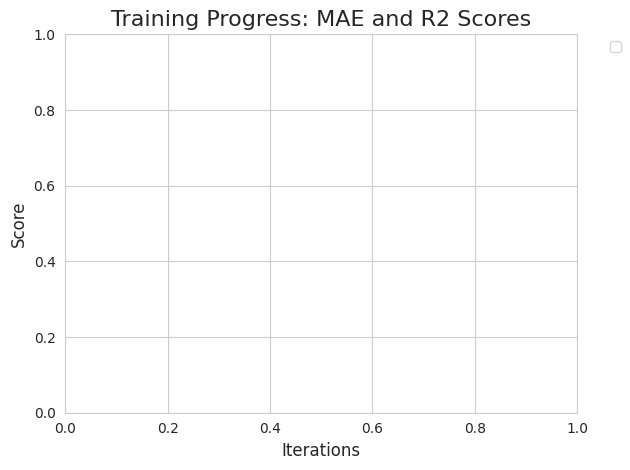

In [23]:
plt.title("Training Progress: MAE and R2 Scores", fontsize=16)
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()